# Efficient portfolios and estimation uncertainty

# Data Selection
This project examines efficient portfolios and estimation uncertainty, drawing inspiration from Portfolio Choice Problems, Brandt 2010. Its primary aim is to assess the impact of statistical errors on portfolio weights and to analyse the potential economic losses that may arise from replacing theoretically optimal portfolio weights with empirical, or "plug-in," estimates. For this analysis, I utilize stocks from the Dow Jones 30 index, applying both the true variance-covariance matrix (denoted as $\Sigma$) and the mean vector ($\mu$), and then comparing these to their simulated counterparts ($\hat{\Sigma}$ and $\hat{\mu}$), which serve as plug-in estimates for calculating portfolio weights. These estimates might deviate from the theoretically true optimal portfolio due to the inherent estimation error.

The project begins with the selection of data for analysis, establishing necessary imports, and setting up the computing environment. I retrieved a sample of the Dow Jones 30 index using the Yahoo! Finance API, collecting historical stock price data for all the stocks within the index from January 1, 2000, to December 31, 2023. The adjusted closing price was selected as the primary price indicator, as it accounts for and adjusts the stock price for corporate actions such as stock splits, dividends, and other similar events, ensuring the data remains unaltered by these factors.

To maintain a representative and consistent dataset, I excluded tickers that had a trading history shorter than the maximum number of trading days observed in the dataset. Consequently, the initial dataset of 30 tickers was reduced to 27, with CRM, DOW, and V being excluded due to their incomplete trading history. Subsequently, I computed the monthly returns for each stock using the formula:

$$r_{i,t} = \frac{p_{i,t} - p_{i,t-1}}{p_{i,t-1}}$$

where $i$ represents the ticker and $t$ represents the date.


In [1]:
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation
import yfinance as yf  # To download financial data
import matplotlib.pyplot as plt  # For data visualization
import ipywidgets as widgets  # For creating interactive UI elements in Jupyter notebooks
from IPython.display import display  # For displaying various outputs in Jupyter notebooks

from dataproject import DowJonesDataAnalyzer  # Custom analysis class

# Initialize analyzer with optional custom dates
dj_analyzer = DowJonesDataAnalyzer()

# Fetch and preprocess Dow Jones data
dj_analyzer.fetch_and_filter_dow_data()

# Calculate and display key financial metrics
metrics = dj_analyzer.calculate_metrics()


[*********************100%%**********************]  30 of 30 completed


Excluded tickers due to missing data: ['DOW', 'V', 'CRM']
        Sample mean  Sharpe ratio
Ticker                           
AAPL      31.332506      0.803601
AMGN      10.549323      0.416387
AXP       11.305131      0.354634
BA        14.446886      0.436234
CAT       18.108026      0.567998
CSCO       6.574028      0.199975
CVX       11.672557      0.490755
DIS        8.542117      0.322018
GS        11.912787      0.373477
HD        12.362509      0.498219
HON       12.497344      0.441317
IBM        7.186086      0.289479
INTC       7.760515      0.231257
JNJ        9.318924      0.568901
JPM       11.954434      0.398950
KO         7.304216      0.419309
MCD       12.884115      0.663582
MMM        8.657974      0.413798
MRK        7.744571      0.330043
MSFT      14.527879      0.518475
NKE       17.323107      0.637611
PG         8.997143      0.506009
TRV       12.868721      0.529386
UNH       22.532055      0.939874
VZ         5.439845      0.246044
WBA        4.122199     

[*********************100%%**********************]  30 of 30 completed


Excluded tickers due to missing data: ['DOW', 'V', 'CRM']


Based on the monthly returns it is possible to calculate the mean, variance-covariance matrix and the shape ratio for each asset. Here all values will be in annualized terms. The computation of annualized values is based on the premise that monthly returns are independent and identically distributed. Consequently, the average annualized return is derived by simply multiplying the expected monthly return by 12 and likewise for the variance-covariance matrix. The mean, $\mu$, variance-covariance matrix, $\Sigma$, and sharpe ratio, $S$, is given by.

$$\mu = 12* \frac{1}{n} \sum_{t=1}^{n} r_{i,t} \hspace{0.4cm}\Sigma=12*\frac{1}{T-1}\sum_{t=1}^T(r_t-\mu)(r_t-\mu)'\hspace{0.4cm} S= \frac{\mu - r_f}{\sigma_p}=\frac{\mu }{\sqrt{12}\sqrt{\text{diag}(\Sigma)}}$$ 
where $r_{i,t}$ is the monthly return of ticker $i$ at time $t$ while $r_f$ is the risk-free rate which is assumed to be zero. Note the notion is not $\hat{\mu}$ and $\hat{\Sigma}$ since I assume that these estimated parameters are the true ones.

The sample mean and sharpe ratio can be seen below. The full variance-covariance matrix can also be seen below as a ($27\times27$) matrix.

In [2]:
# Calculate and print financial metrics for each ticker in the dataset.
# This includes annualized mean returns, variance-covariance matrix, standard deviations, and Sharpe ratios.
dj_analyzer.calculate_financial_metrics()


        Sample mean  Sharpe ratio
Ticker                           
AAPL      31.332506      0.803601
AMGN      10.549323      0.416387
AXP       11.305131      0.354634
BA        14.446886      0.436234
CAT       18.108026      0.567998
CSCO       6.574028      0.199975
CVX       11.672557      0.490755
DIS        8.542117      0.322018
GS        11.912787      0.373477
HD        12.362509      0.498219
HON       12.497344      0.441317
IBM        7.186086      0.289479
INTC       7.760515      0.231257
JNJ        9.318924      0.568901
JPM       11.954434      0.398950
KO         7.304216      0.419309
MCD       12.884115      0.663582
MMM        8.657974      0.413798
MRK        7.744571      0.330043
MSFT      14.527879      0.518475
NKE       17.323107      0.637611
PG         8.997143      0.506009
TRV       12.868721      0.529386
UNH       22.532055      0.939874
VZ         5.439845      0.246044
WBA        4.122199      0.154850
WMT        7.904413      0.425472
Ticker with ma

The stock in The Dow Jones Index with the highest Sharpe ratio is UNH (UnitedHealth Group Inc.) with a ratio of 0.939874. This indicates that for every unit of risk taken, UNH yields a return of 0.939874 above the risk-free rate, which is relatively high compared to the other stocks in the Dow Jones 30 Index. On the other hand, Walgreens Boots Alliance (WBA) has the lowest Sharpe ratio at 0.154850. 


# Efficient Frontier

In the following, a function named `compute_efficient_frontier` is defined. It constructs the efficient frontier for a given positive definite variance-covariance matrix and expected return vector. It takes two inputs: "Sigma," which is an $N \times N$ positive definite variance-covariance matrix, and "mu," which is the vector of expected returns. The function's initial step is to compute the minimum variance portfolio weight, named "mvp," which is the portfolio with the lowest volatility for a given expected return. It is calculated as below:
$$\omega_{\text{mvp}} = \operatorname*{arg min}_w w'\Sigma w \ \text{s.t.} \sum_{i=1}^N w_i = 1$$
The next step in the function is to compute the efficient portfolio weights for a portfolio that delivers a higher expected return compared to the minimum variance portfolio. This is calculated as:
$$\omega_{\text{eff}} = \operatorname*{arg min}_w w'\Sigma w \ \text{s.t.} \ w' \iota = 1 \hspace{0.1cm} \text{and} \hspace{0.1cm} w'\mu \geq \bar{\mu}$$
where $\bar{\mu}$ is set to two times the minimum variance portfolio's expected return.

The function then utilizes the two-mutual fund theorem to compute a sequence of portfolio weights on the efficient frontier using combinations of the minimum variance portfolio and the efficient portfolio. These portfolio weights are a linear combination and range from $c = -4$ to $c = 3$.

$$w_c=c\cdot w_{\text{MVP}}+(1-c)\cdot w_{\text{eff}}(\bar{\mu}),\hspace{0.3cm}c\in\{-4,\ldots,3\}$$

Additionally, the function calculates the weights for the efficient tangent portfolio, which maximizes the Sharpe ratio. This portfolio, denoted as `wtgc`, is calculated by solving the equation $\Sigma w = \mu$, and then normalizing the weights so their sum equals 1. This portfolio represents an optimal mix of assets offering the highest expected return per unit of risk.

The output of this function can be used to plot the efficient frontier in a diagram with volatility on the x-axis and expected returns on the y-axis based on the input values of "Sigma" and "mu" showcasing a range of portfolios that offer the highest expected return for a given level of risk.

For portfolios on the efficient frontier, including the minimum variance portfolio and the efficient tangent portfolio, the weights are calculated and stored. These can be distinctly marked on the efficient frontier to illustrate their positions relative to individual stocks, which are also plotted based on their volatility and expected return. The minimum variance portfolio is identified as the portfolio with the lowest volatility, and the efficient tangent portfolio is marked for its optimal risk-return balance, based on the calculated Sharpe ratio.

Additionally, the function is designed to differentiate between simulated and theoretical calculations, a capability that proves essential for subsequent analyses.

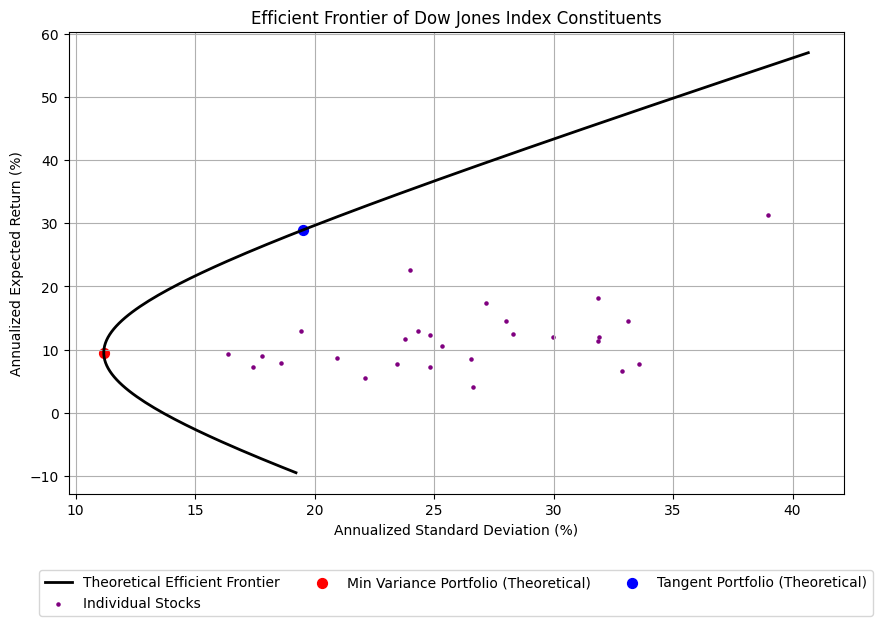

In [3]:
# Compute the efficient frontier from monthly returns.
dj_analyzer.compute_efficient_frontier(dj_analyzer.mu, dj_analyzer.Sigma, simulated=False)

# Setup plot dimensions.
plt.figure(figsize=(10, 6))

# Plot the theoretical efficient frontier.
plt.plot(dj_analyzer.ef_points_theoretical['sd'], dj_analyzer.ef_points_theoretical['mu'], label='Theoretical Efficient Frontier', color="black", linewidth=2)

# Scatter plot for individual stocks.
plt.scatter(dj_analyzer.SD, dj_analyzer.mu, color='purple', s=5, label='Individual Stocks')

# Plot minimum variance and tangent portfolios.
plt.scatter(dj_analyzer.min_theoretical['sd'], dj_analyzer.min_theoretical['mu'], color='red', s=50, label='Min Variance Portfolio (Theoretical)')
plt.scatter(dj_analyzer.tan_theoretical['sd'], dj_analyzer.tan_theoretical['mu'], color='blue', s=50, label='Tangent Portfolio (Theoretical)')

# Axis labels and plot title.
plt.xlabel('Annualized Standard Deviation (%)')
plt.ylabel('Annualized Expected Return (%)')
plt.title('Efficient Frontier of Dow Jones Index Constituents')

# Adjust legend below the plot.
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.grid(True)  # Enable grid.
plt.show()  # Display the plot.


# Efficient Tangent Portfolio

The efficient tangent portfolio is the portfolio on the efficient frontier that has the highest Sharpe ratio, given the risk-free rate of return. It is calculated as below based on the true parameters $\mu$ and $\Sigma$ from before and under the assumption of a risk free rate at zero.

$$
\omega_{tgc} = \frac{\Sigma^{-1} (\mu - r_f)}{\iota ' \Sigma^{-1} (\mu - r_f)}
$$

Below presents the weights for the efficient tangency portfolio, the expected annual return, standard deviation, and Sharpe ratio calculated form the function used before. The portfolio's Sharpe ratio is calculated to be 1.48, reflecting its efficiency as the highest possible ratio when compared with individual assets listed before. The higher value comes from the portfolio's diversification, which includes a mix of both long and short positions across different assets within the Dow Jones 30 index. The efficient tangent portfolio thus inherently carries a higher Sharpe ratio than any individual asset, due to the diversification benefits. In the plot above it becomes apparent that the portfolio possesses the maximum possible Sharpe ratio, thereby dominating all individual assets.

The portfolio's balance depends on risk tolerance, investment horizon, and financial objectives. The efficient tangency portfolio weight below shows a sectoral bias towards healthcare stocks like UNH and JNJ, while taking short positions in INTC, DIS, and AXP to reduce potential losses. These conclusions are based on historical data and don't consider future market changes. Implementing the portfolio may be complicated due to the negative weights representing short-selling, which carries risks and may not be allowed in all accounts. It assumes a zero risk-free rate and accurate parameters, which may not be true. Transaction and borrowing costs were not included, which can also impact portfolio performance. Therefore, this theoretical calculation might not fully capture the uncertainties present in real-life scenarios.

In [4]:
# Displaying the calculated weights for each asset in the efficient tangent portfolio.
weights_df = pd.DataFrame({'Ticker': dj_analyzer.mu.index, 'Weight': dj_analyzer.wtgc})
print("Portfolio Weights:")
print(weights_df.to_string(index=False))  

# Presenting key portfolio metrics: expected annual return, standard deviation (risk), and Sharpe ratio (risk-adjusted return).
metrics_df = pd.DataFrame({
    "Metric": ["Expected Return", "Standard Deviation", "Sharpe Ratio"],
    "Value": [dj_analyzer.tan_theoretical['mu'], dj_analyzer.tan_theoretical['sd'], dj_analyzer.sharpe_ratio_theoretical]
})
print("\nPortfolio Metrics:")
print(metrics_df.to_string(index=False)) 


Portfolio Weights:
Ticker    Weight
  AAPL  0.309768
  AMGN  0.106419
   AXP -0.118044
    BA  0.105273
   CAT  0.157892
  CSCO -0.056540
   CVX  0.000487
   DIS -0.183582
    GS -0.116046
    HD  0.034012
   HON  0.053880
   IBM -0.109097
  INTC -0.169125
   JNJ  0.181375
   JPM  0.044392
    KO -0.062105
   MCD  0.125901
   MMM -0.182335
   MRK -0.100379
  MSFT  0.168042
   NKE  0.165610
    PG  0.235240
   TRV  0.177205
   UNH  0.413077
    VZ -0.088213
   WBA -0.141093
   WMT  0.047984

Portfolio Metrics:
            Metric     Value
   Expected Return 28.920373
Standard Deviation 19.502445
      Sharpe Ratio  1.482910


# Efficient Frontier Simulation
To analyze different scenarios that may have affected the true calculations from before, an analysis of simulated returns is done. A simulation of the efficient frontier will be performed using the function. The simulate returns function generates a set of simulated returns using a multivariate normal distribution. It requires three input parameters: the number of periods to simulate (set to 200 below), the expected returns of each asset in the portfolio (mu), and the variance-covariance matrix of the assets (Sigma). It is seen in the figure below. The simulation spans 200 periods and estimates the annual expected return ($\hat{\mu}$) and variance-covariance matrix ($\hat{\Sigma}$).

In the figure below, the theoretical efficient frontier is displayed as the black line, representing the optimal portfolios based on perfect knowledge of return distributions (the frontier from before). However, in practice, investors often lack such complete information in future times. The blue line represents the efficient frontier based on sample estimates of mean and covariance matrix from the simulated return function. It reflects the choices investors would likely make given available data and real-world information constraints. The estimated frontier deviates from the theoretical due to possible sampling error and potential biases generated from the simulation. Consequently, portfolios selected using sample estimates may be less efficient compared to those grounded in the true parameters, resulting in a divergence between the theoretical and sample-based efficient frontiers.

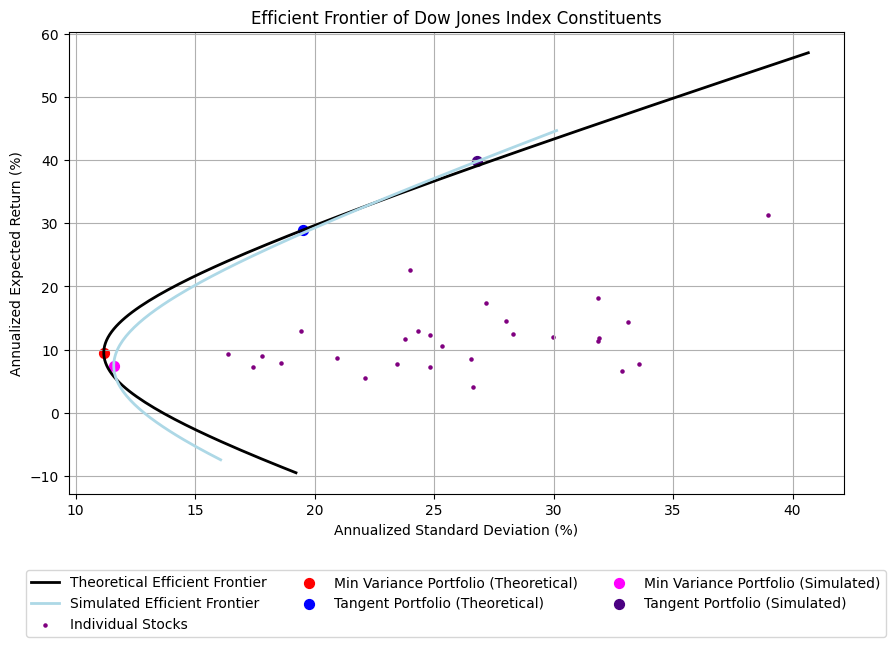

In [5]:
# Set the seed for reproducibility
np.random.seed(2023)

# Then, we simulate the returns and compute the efficient frontier for the simulation.
simulated_returns = dj_analyzer.simulate_returns(periods=200, expected_returns=dj_analyzer.mu, covariance_matrix=dj_analyzer.Sigma)
sample_mu = np.mean(simulated_returns, axis=0)
sample_Sigma = np.cov(simulated_returns.T, ddof=0)

# After computing the frontier with simulated data
simulated_ef_points = dj_analyzer.compute_efficient_frontier(sample_mu, sample_Sigma,simulated=True)

# Now let's plot both efficient frontiers together.
plt.figure(figsize=(10, 6))

# Plotting the theoretical efficient frontier as a line
plt.plot(dj_analyzer.ef_points_theoretical['sd'], dj_analyzer.ef_points_theoretical['mu'], label='Theoretical Efficient Frontier', color="black", linewidth=2)

# Plotting the efficient frontier for the simulated returns as a line
plt.plot(dj_analyzer.ef_points_simulated['sd'], dj_analyzer.ef_points_simulated['mu'], label='Simulated Efficient Frontier', color="lightblue", linewidth=2)

# Plotting individual stocks
plt.scatter(dj_analyzer.SD, dj_analyzer.mu, color='purple', s=5, label='Individual Stocks')

# Plotting minimum variance portfolio and tangent portfolio for the theoretical returns
plt.scatter(dj_analyzer.min_theoretical['sd'], dj_analyzer.min_theoretical['mu'], color='red', s=50, label='Min Variance Portfolio (Theoretical)')
plt.scatter(dj_analyzer.tan_theoretical['sd'], dj_analyzer.tan_theoretical['mu'], color='blue', s=50, label='Tangent Portfolio (Theoretical)')

# Plotting minimum variance portfolio and tangent portfolio for the simulated returns
plt.scatter(dj_analyzer.min_simulated['sd'], dj_analyzer.min_simulated['mu'], color='magenta', s=50, label='Min Variance Portfolio (Simulated)')
plt.scatter(dj_analyzer.tan_simulated['sd'], dj_analyzer.tan_simulated['mu'], color='indigo', s=50, label='Tangent Portfolio (Simulated)')

plt.xlabel('Annualized Standard Deviation (%)')  # Label for the x-axis indicating risk.
plt.ylabel('Annualized Expected Return (%)')  # Label for the y-axis indicating reward.
plt.title('Efficient Frontier of Dow Jones Index Constituents')  # Title of the plot.

# Adjusting the legend to be placed below the plot for clear visibility without overlapping the graph.
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.grid(True)  # Enable grid for easier interpretation of the plot.
plt.show()  # Display the plot, showcasing the efficient frontier and other relevant data points.


# Efficient Frontier Simulation Over Different Periods
In the figure presented, the looped simulation's outcome for various sample sizes ($t \in {50, 300, 900, 10,000}$) is displayed, offering a visual comparison against the theoretical efficient frontier. The simulations exhibit varying degrees of deviation from the theoretical frontier, with the discrepancies diminishing as sample sizes increase. For $t=50$, the wide divergence underscores the greater uncertainty in estimations from small samples. As we progress to larger sample sizes, such as $t=300$ and $t=900$, the simulated frontiers coalesce more closely to the theoretical line, suggesting enhanced accuracy in the estimation of expected returns and covariances.

The simulations for $t=10,000$ show a notable alignment with the theoretical frontier, reinforcing the principle that larger sample sizes tend to yield estimates that are more representative of the true parameters. This pattern demonstrates the statistical consistency afforded by the law of large numbers—larger samples provide a more reliable basis for constructing the efficient frontier. Nonetheless, it is important to bear in mind that real-world factors and market anomalies may still lead to departures from these theoretical predictions. 

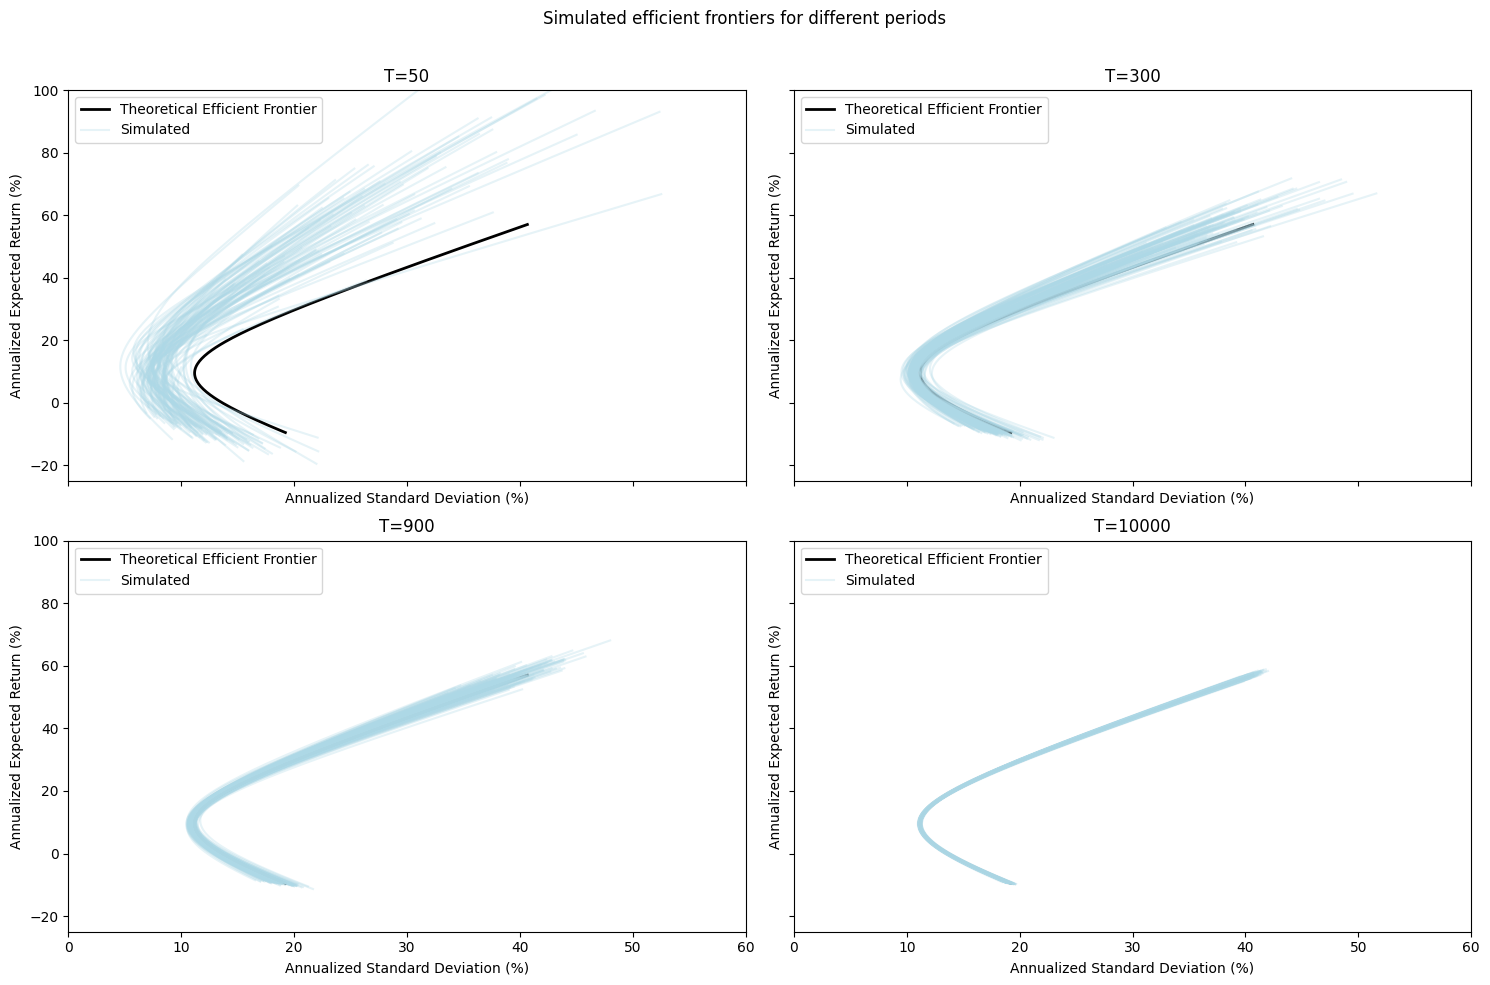

In [6]:
# Define the periods for which we want to simulate
periods_to_simulate = [50, 300, 900, 10000]

#Define the number of simulations each
num_simulations = 100

# Set up the figure for plotting
fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)  # sharex and sharey for same scale
axs = axs.flatten()  # Flatten the 2x2 array for easy iteration
fig.suptitle('Simulated efficient frontiers for different periods')

# Define global axis limits
x_min, x_max = 0, 60  # Example x-axis (standard deviation) limits
y_min, y_max = -25, 100  # Example y-axis (expected return) limits

# Iterate over the defined periods and simulations
for i, periods in enumerate(periods_to_simulate):
    # Plot the theoretical efficient frontier first so it's below the simulations
    axs[i].plot(dj_analyzer.ef_points_theoretical['sd'], dj_analyzer.ef_points_theoretical['mu'], color="black", linewidth=2, label='Theoretical Efficient Frontier')

    for _ in range(num_simulations):
        # Simulate the returns for the given period
        simulated_returns = dj_analyzer.simulate_returns(periods=periods, expected_returns=dj_analyzer.mu, covariance_matrix=dj_analyzer.Sigma)
        sample_mu = np.mean(simulated_returns, axis=0)
        sample_Sigma = np.cov(simulated_returns.T, ddof=0)
        
        # Compute the efficient frontier for the simulated data
        dj_analyzer.compute_efficient_frontier(sample_mu, sample_Sigma, simulated=True)
        
        # Plot the efficient frontier for the simulated returns on the appropriate subplot
        # Add a label only once to avoid duplicate legend entries
        axs[i].plot(dj_analyzer.ef_points_simulated['sd'], dj_analyzer.ef_points_simulated['mu'], alpha=0.3, color="lightblue", label='Simulated' if _ == 0 else "")

    # Set the axis limits
    axs[i].set_xlim(x_min, x_max)
    axs[i].set_ylim(y_min, y_max)

    # Label each subplot with the number of periods
    axs[i].set_title(f'T={periods}')
    axs[i].set_xlabel('Annualized Standard Deviation (%)')
    axs[i].set_ylabel('Annualized Expected Return (%)')
    
    # Add a legend to each subplot
    axs[i].legend(loc='upper left')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust the top spacing to accommodate the main title
plt.show()


Below, you can adjust the number of simulations and the duration of each simulation period using the provided sliders. This allows you to dynamically explore how different settings impact the outcomes. Experiment with these settings to visualize variations in the simulated efficient frontiers directly.

In [7]:
from dataproject import InteractivePlot

# Initialize the interactive plot
interactive_plot = InteractivePlot(dj_analyzer)

# Display the interactive plot
display(interactive_plot.display())


# Conclusion

In conclusion, this project has successfully demonstrated the application of statistical methods to estimate and analyze the efficient frontier, a cornerstone concept in portfolio theory. Through both theoretical and simulated approaches, I have observed how increasing sample sizes can significantly improve the accuracy of frontier estimations, thereby guiding investors towards more informed decisions. However, the simulations also highlight the limitations inherent in historical data and mathematical models, reminding us of the unpredictable nature of financial markets. Ultimately, while our analysis provides valuable insights into optimal portfolio construction, it also underscores the importance of considering a range of factors—including market conditions, investment goals, and risk tolerance—in investment strategy formulation.